In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings

warnings.filterwarnings('ignore') 
sns.set(style="whitegrid")

In [2]:
print("TAHAP 0: Mempersiapkan Dataset CARDETAIL-1000.csv...")

# 1. Muat Data
try:
    df = pd.read_csv('CARDETAIL-1000.csv')
    print(f"Data awal dimuat: {df.shape}")
except FileNotFoundError:
    # Membuat dummy data jika file tidak ditemukan di env lokal saat testing
    print("File tidak ditemukan, pastikan path file benar.")
    df = pd.DataFrame() 

TAHAP 0: Mempersiapkan Dataset CARDETAIL-1000.csv...
Data awal dimuat: (1000, 8)


In [3]:
# 2. Feature Engineering Sederhana
# Ekstrak Merk dari 'name' agar tidak terlalu banyak fitur unik
df['Brand'] = df['name'].str.split().str.get(0)
df.drop('name', axis=1, inplace=True)

In [4]:
# 3. Encoding (Mengubah teks menjadi angka)
# Target Klasifikasi (Kita gunakan Transmission: Manual=0, Automatic=1)
df['Response'] = df['transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)
df.drop('transmission', axis=1, inplace=True)

# Target Regresi adalah 'selling_price' (Income equivalent)
# Kita ganti nama agar sesuai konteks kode referensi
df.rename(columns={'selling_price': 'Income'}, inplace=True)

# Encoding variabel kategorikal lainnya (Fuel, Seller_Type, Owner, Brand)
cat_cols = ['fuel', 'seller_type', 'owner', 'Brand']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [5]:
# 4. Scaling (Penting untuk LASSO dan PCA)
# Kita scale fitur numerik selain target
num_cols = ['year', 'km_driven']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [6]:
# 5. Split Data menjadi Train dan Test (Meniru input file preprocessing2)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Data latih (train_df): {train_df.shape}")
print(f"Data uji (test_df): {test_df.shape}")
print("-" * 30)

Data latih (train_df): (800, 33)
Data uji (test_df): (200, 33)
------------------------------


In [7]:
# BAGIAN A: TUGAS KLASIFIKASI (Target: Response / Transmission Type)

print("\nMemulai Bagian A: Persiapan Data Klasifikasi (Target: Transmission Type)")

# 1. Pisahkan X dan y untuk Klasifikasi
# Kita drop 'Income' (target regresi) agar tidak bocor ke klasifikasi
y_class_train = train_df['Response']
y_class_test = test_df['Response']
X_class_train = train_df.drop(['Response', 'Income'], axis=1)
X_class_test = test_df.drop(['Response', 'Income'], axis=1)

print(f"Bentuk X_class_train: {X_class_train.shape}")


Memulai Bagian A: Persiapan Data Klasifikasi (Target: Transmission Type)
Bentuk X_class_train: (800, 31)


In [8]:
# A.1: Skenario Seleksi Fitur (LASSO L1) untuk Klasifikasi
print("\nA.1: Menjalankan Seleksi Fitur LASSO (Klasifikasi)")

# Menggunakan LogisticRegression dengan penalti L1
l1_model_class = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', random_state=42)
l1_selector = SelectFromModel(l1_model_class, max_features=15)

l1_selector.fit(X_class_train, y_class_train)

# Ambil koefisien
l1_coefs = l1_selector.estimator_.coef_[0]
l1_coefs_df = pd.DataFrame({
    'Feature': X_class_train.columns,
    'Importance (Abs Coef)': np.abs(l1_coefs)
}).sort_values(by='Importance (Abs Coef)', ascending=False)

# Ambil fitur yang lolos seleksi
selected_features_class = X_class_train.columns[l1_selector.get_support()]
print(f"LASSO memilih {len(selected_features_class)} fitur untuk Klasifikasi.")
print("Top 5 Fitur:", list(selected_features_class)[:5])

# Simpan hasil seleksi
X_class_train_selected = X_class_train[selected_features_class]
X_class_test_selected = X_class_test[selected_features_class]
# X_class_train_selected.to_csv('X_class_train_selected_car.csv', index=False) # Opsional simpan


A.1: Menjalankan Seleksi Fitur LASSO (Klasifikasi)
LASSO memilih 3 fitur untuk Klasifikasi.
Top 5 Fitur: ['year', 'seller_type_Individual', 'Brand_Maruti']


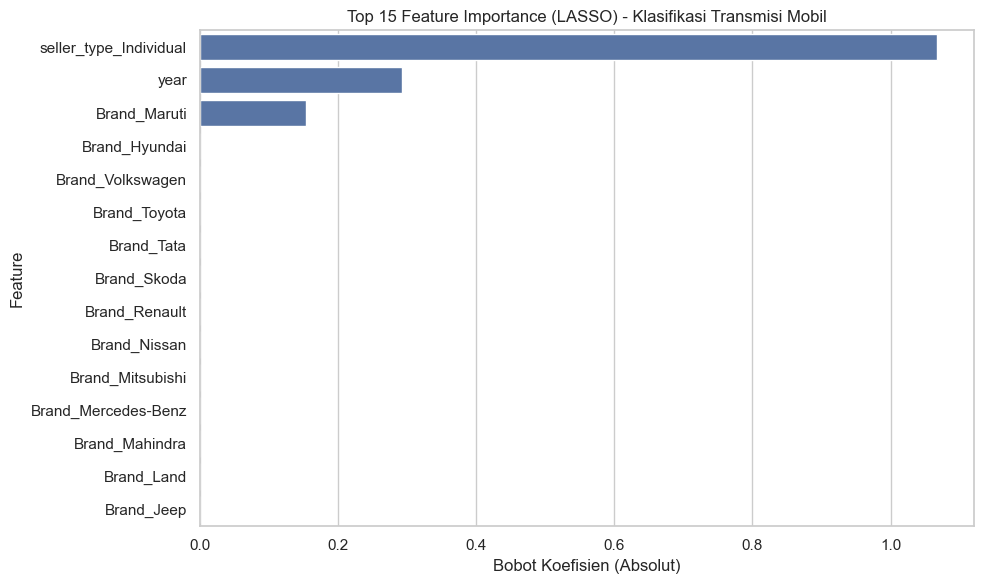

In [9]:
# --- Plot A.1: Visualisasi Seleksi Fitur LASSO ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance (Abs Coef)', y='Feature', data=l1_coefs_df.head(15))
plt.title('Top 15 Feature Importance (LASSO) - Klasifikasi Transmisi Mobil')
plt.xlabel('Bobot Koefisien (Absolut)')
plt.tight_layout()
plt.show()

In [10]:
# A.2: Skenario Reduksi Dimensi (PCA) untuk Klasifikasi
print("\nA.2: Menjalankan PCA (Klasifikasi)")

# Fit PCA
pca_class = PCA(n_components=0.95, random_state=42)
pca_class.fit(X_class_train) # Menggunakan semua fitur numerik/encoded
print(f"PCA memilih {pca_class.n_components_} komponen untuk mempertahankan 95% varians.")

# Transformasi
X_train_pca_transformed = pca_class.transform(X_class_train)
X_test_pca_transformed = pca_class.transform(X_class_test)


A.2: Menjalankan PCA (Klasifikasi)
PCA memilih 14 komponen untuk mempertahankan 95% varians.


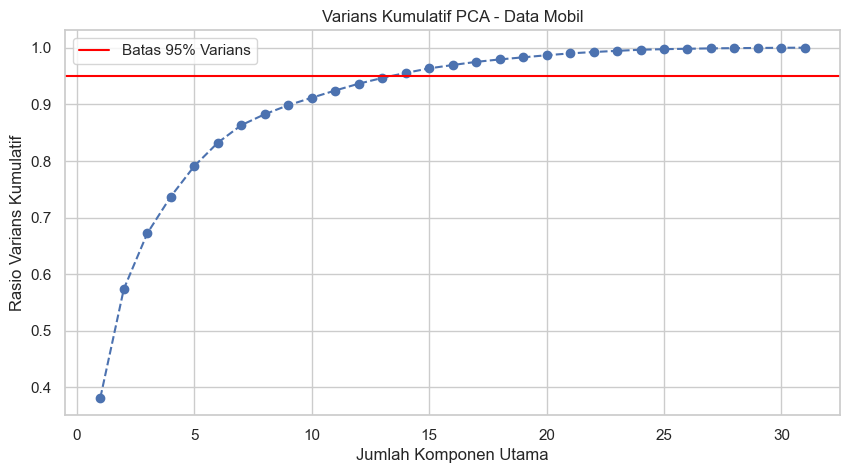

In [11]:
# --- Plot A.2: Visualisasi Varians Kumulatif PCA ---
pca_full_class = PCA(random_state=42).fit(X_class_train)
cumulative_variance = np.cumsum(pca_full_class.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='red', linestyle='-', label='Batas 95% Varians')
plt.title('Varians Kumulatif PCA - Data Mobil')
plt.xlabel('Jumlah Komponen Utama')
plt.ylabel('Rasio Varians Kumulatif')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# ==========================================
# BAGIAN B: TUGAS REGRESI (Target: Income / Selling Price)
# ==========================================

print("-" * 30)
print("Memulai Bagian B: Persiapan Data Regresi (Target: Selling Price)")

y_reg_train = train_df['Income']
y_reg_test = test_df['Income']
# Untuk regresi, kita bisa menggunakan 'Response' (Transmisi) sebagai fitur
X_reg_train = train_df.drop('Income', axis=1)
X_reg_test = test_df.drop('Income', axis=1)

print(f"Bentuk X_reg_train: {X_reg_train.shape}")

------------------------------
Memulai Bagian B: Persiapan Data Regresi (Target: Selling Price)
Bentuk X_reg_train: (800, 32)


In [13]:
# B.1: Skenario Seleksi Fitur (LASSO) untuk Regresi
print("\nB.1: Menjalankan Seleksi Fitur LASSO (Regresi)")

l1_reg_model = Lasso(alpha=100, random_state=42) # Alpha disesuaikan karena skala harga besar
l1_reg_selector = SelectFromModel(l1_reg_model, max_features=15)

l1_reg_selector.fit(X_reg_train, y_reg_train)

# Ambil koefisien
l1_reg_coefs = l1_reg_selector.estimator_.coef_
l1_reg_coefs_df = pd.DataFrame({
    'Feature': X_reg_train.columns,
    'Importance (Abs Coef)': np.abs(l1_reg_coefs)
}).sort_values(by='Importance (Abs Coef)', ascending=False)

selected_features_reg = X_reg_train.columns[l1_reg_selector.get_support()]
print(f"LASSO memilih {len(selected_features_reg)} fitur untuk Regresi.")


B.1: Menjalankan Seleksi Fitur LASSO (Regresi)
LASSO memilih 15 fitur untuk Regresi.


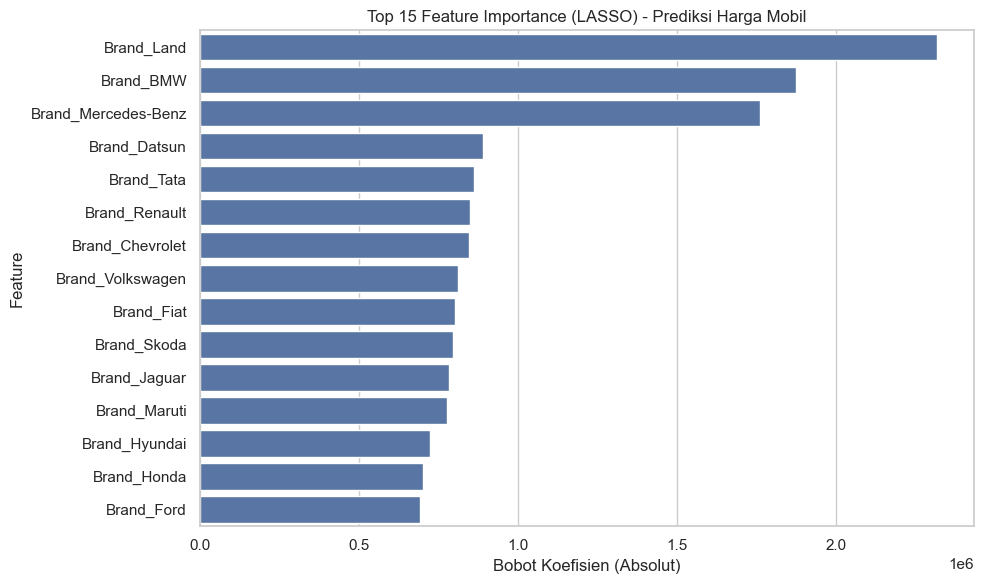

In [14]:
# --- Plot B.1: Visualisasi Seleksi Fitur LASSO (Regresi) ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance (Abs Coef)', y='Feature', data=l1_reg_coefs_df.head(15))
plt.title('Top 15 Feature Importance (LASSO) - Prediksi Harga Mobil')
plt.xlabel('Bobot Koefisien (Absolut)')
plt.tight_layout()
plt.show()


B.2: Menjalankan PCA (Regresi)


PCA memilih 15 komponen untuk Regresi.


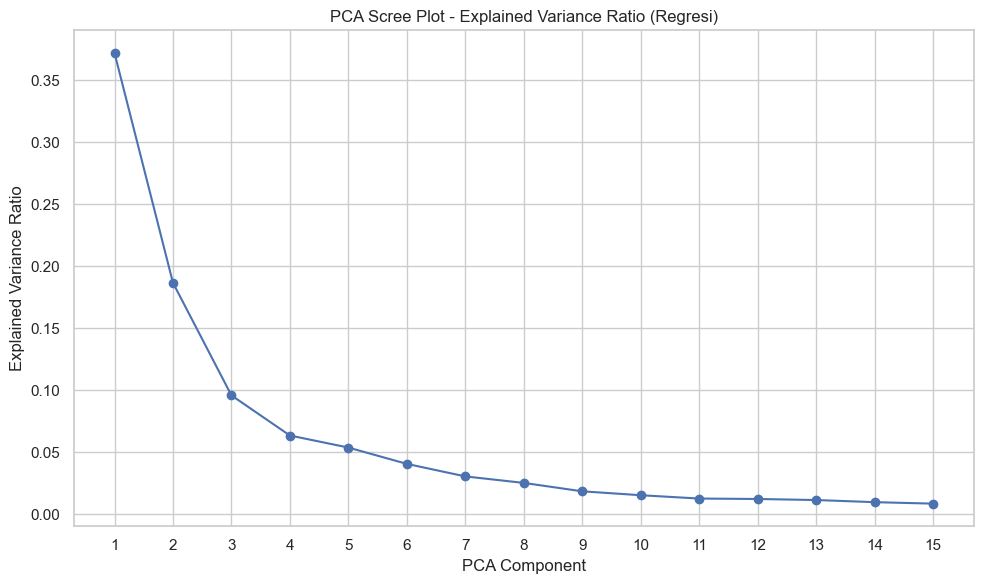

In [15]:
# B.2: Menjalankan PCA (Regresi)
print("\nB.2: Menjalankan PCA (Regresi)")
pca_reg = PCA(n_components=0.95, random_state=42)
pca_reg.fit(X_reg_train)
print(f"PCA memilih {pca_reg.n_components_} komponen untuk Regresi.")
# --- Plot B.2: Scree Plot PCA (Regresi) ---
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca_reg.explained_variance_ratio_) + 1),
    pca_reg.explained_variance_ratio_,
    marker='o'
)
plt.title('PCA Scree Plot - Explained Variance Ratio (Regresi)')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca_reg.explained_variance_ratio_) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# TAHAP 3: SIMPAN TARGET (Opsional / Mockup)
print("\n[Info]: Proses selesai. File siap disimpan sesuai logika preprocessing2.")
# y_class_train.to_csv('y_class_train_car.csv', index=False)
# y_reg_train.to_csv('y_reg_train_car.csv', index=False)


[Info]: Proses selesai. File siap disimpan sesuai logika preprocessing2.
